In [1]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import keras

from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from datetime import datetime

tf.compat.v1.disable_eager_execution()

In [2]:
class DQN:
    def __init__(self, env, tau=0.003, gamma=0.99, hidden_size=64, learning_rate=0.0005, batch_size=32):
        self.env = env
        self.tau = tau
        self.gamma = gamma
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.C = 4
        self.memory = deque(maxlen=100000)
        self.count = 0
        
        self.Q, self.target_Q  = self.QNetwork(), self.QNetwork()
    
    def QNetwork(self, state_size=8, action_size=4):
        model = Sequential()
        # we should try different activation function and compare them
        model.add(Dense(self.hidden_size, activation="relu"))
        model.add(Dense(self.hidden_size, activation="relu"))
        model.add(Dense(action_size))
        model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        return model
    
    def memory_append(self, experience):
        self.memory.append(experience)
    
    def action(self, state, epsilon):
        if np.random.random() >= epsilon:
            return np.argmax(self.Q.predict(state)[0])
        else:
            return self.env.action_space.sample()
    
    def train_weight(self):
        weights = self.Q.get_weights()
        target_weights = self.target_Q.get_weights()
        for i, _ in enumerate(weights):
            target_weights[i] = target_weights[i] + self.tau * (weights[i] - target_weights[i])
        self.target_Q.set_weights(target_weights)
        
    def learn(self):
        self.count += 1
        self.count %= self.C
        if len(self.memory) < self.batch_size:
            return None
        batch_state, batch_target = [], []
        sample_batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in sample_batch:
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.amax(self.target_Q.predict(next_state)[0])
            target_val = self.Q.predict(state)
            target_val[0][action] = target

            batch_state.append(state[0])
            batch_target.append(target_val[0])
        self.Q.fit(np.array(batch_state), np.array(batch_target), epochs=1, verbose=0)
        if self.count == 0:
            self.train_weight()
    
    def save(self, file):
        self.Q.save(file)

In [3]:
# Training
def train(gamma=0.99, learning_rate=0.0005, name="test", decay_rate=0.0001, batch_size=32, tau=0.003):
    env = gym.make("LunarLander-v2")
    train_episodes = 2000 
    max_steps = 1000
    epsilon=1.0
    epsilon_stop=0.01
    
    # create a score window to terminate training early
    score = []
    score_moving_window = deque(maxlen=100)
    epsilons = []
    # create the agent
    agent = DQN(env=env, learning_rate=learning_rate, gamma=gamma, batch_size=batch_size, tau=tau)
    
    for episode in range(1, train_episodes):
        total_reward = 0
        step = 0
        state = env.reset().reshape(1, 8)
        epsilons.append(epsilon)
        while step < max_steps:
            step += 1
            
            # use epsilon greedy policy to get action
            action = agent.action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1,8])
            total_reward += reward

            # add the transition to replay memory
            agent.memory_append((state, action, reward, next_state, done))
            
            # learn
            agent.learn()
            state = next_state

            if done:
                break
        
        # record score and score window
        score.append(total_reward)
        score_moving_window.append(total_reward)
        # update epsilon
        epsilon = epsilon_stop + (epsilon - epsilon_stop)*np.exp(-decay_rate*step)
        print('Episode: {}'.format(episode),
              'Total reward: {}'.format(total_reward),
              'Mean score: {}'.format(np.mean(score_moving_window)),
              'Explore P: {}'.format(epsilon),
              datetime.now().time())
        if np.mean(score_moving_window) >= 220:
            agent.save(name)
            print("\n Achieve Mean Score of 220 over last 100 episodes with total {} episodes!".format(episode))
            break
    agent.save(name)
    print(print("\n Not achieve Mean Score of 220 over past 100 episodes with total {} episodes!".format(episode)))
    env.close()
    return (score, epsilons)

In [4]:
batch_sizes = [8, 16, 32, 64, 128]
scores, epsilons = [0,0,0,0,0], [0,0,0,0,0]

In [5]:
for _, batch_size in enumerate(batch_sizes):
    scores[_], epsilons[_] = train(batch_size=batch_size, name="batch_size"+str(batch_size))
    pd.Series(scores[_]).to_csv("scores_batch_size"+str(batch_size))
    pd.Series(epsilons[_]).to_csv("epsilons_batch_size"+str(batch_size))

/Users/shideqiu/anaconda3/envs/ai_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode: 1 Total reward: -107.67637495848402 Mean score: -107.67637495848402 Explore P: 0.9889738616345055 00:39:09.197188
Episode: 2 Total reward: -206.1456441816403 Mean score: -156.91100957006216 Explore P: 0.980979099291975 00:39:10.189531
Episode: 3 Total reward: -137.39873302121597 Mean score: -150.40691738711345 Explore P: 0.9701648064649078 00:39:11.348317
Episode: 4 Total reward: -105.77984265276004 Mean score: -139.2501487035251 Explore P: 0.9620379934952048 00:39:12.235313
Episode: 5 Total reward: -206.4486395685554 Mean score: -152.68984687653113 Explore P: 0.9554915425688074 00:39:12.948870
Episode: 6 Total reward: 17.928771181676694 Mean score: -124.2534105334965 Explore P: 0.9458965465030128 00:39:14.052143
Episode: 7 Total reward: -210.64988982179383 Mean score: -136.595764717539 Explore P: 0.9369549280964593 00:39:15.073747
Episode: 8 Total reward: -143.05731044113367 Mean score: -137.40345793298832 Explore P: 0.9252570393322377 00:39:16.375271
Episode: 9 Total reward:

KeyboardInterrupt: 

Text(0, 0.5, 'Score')

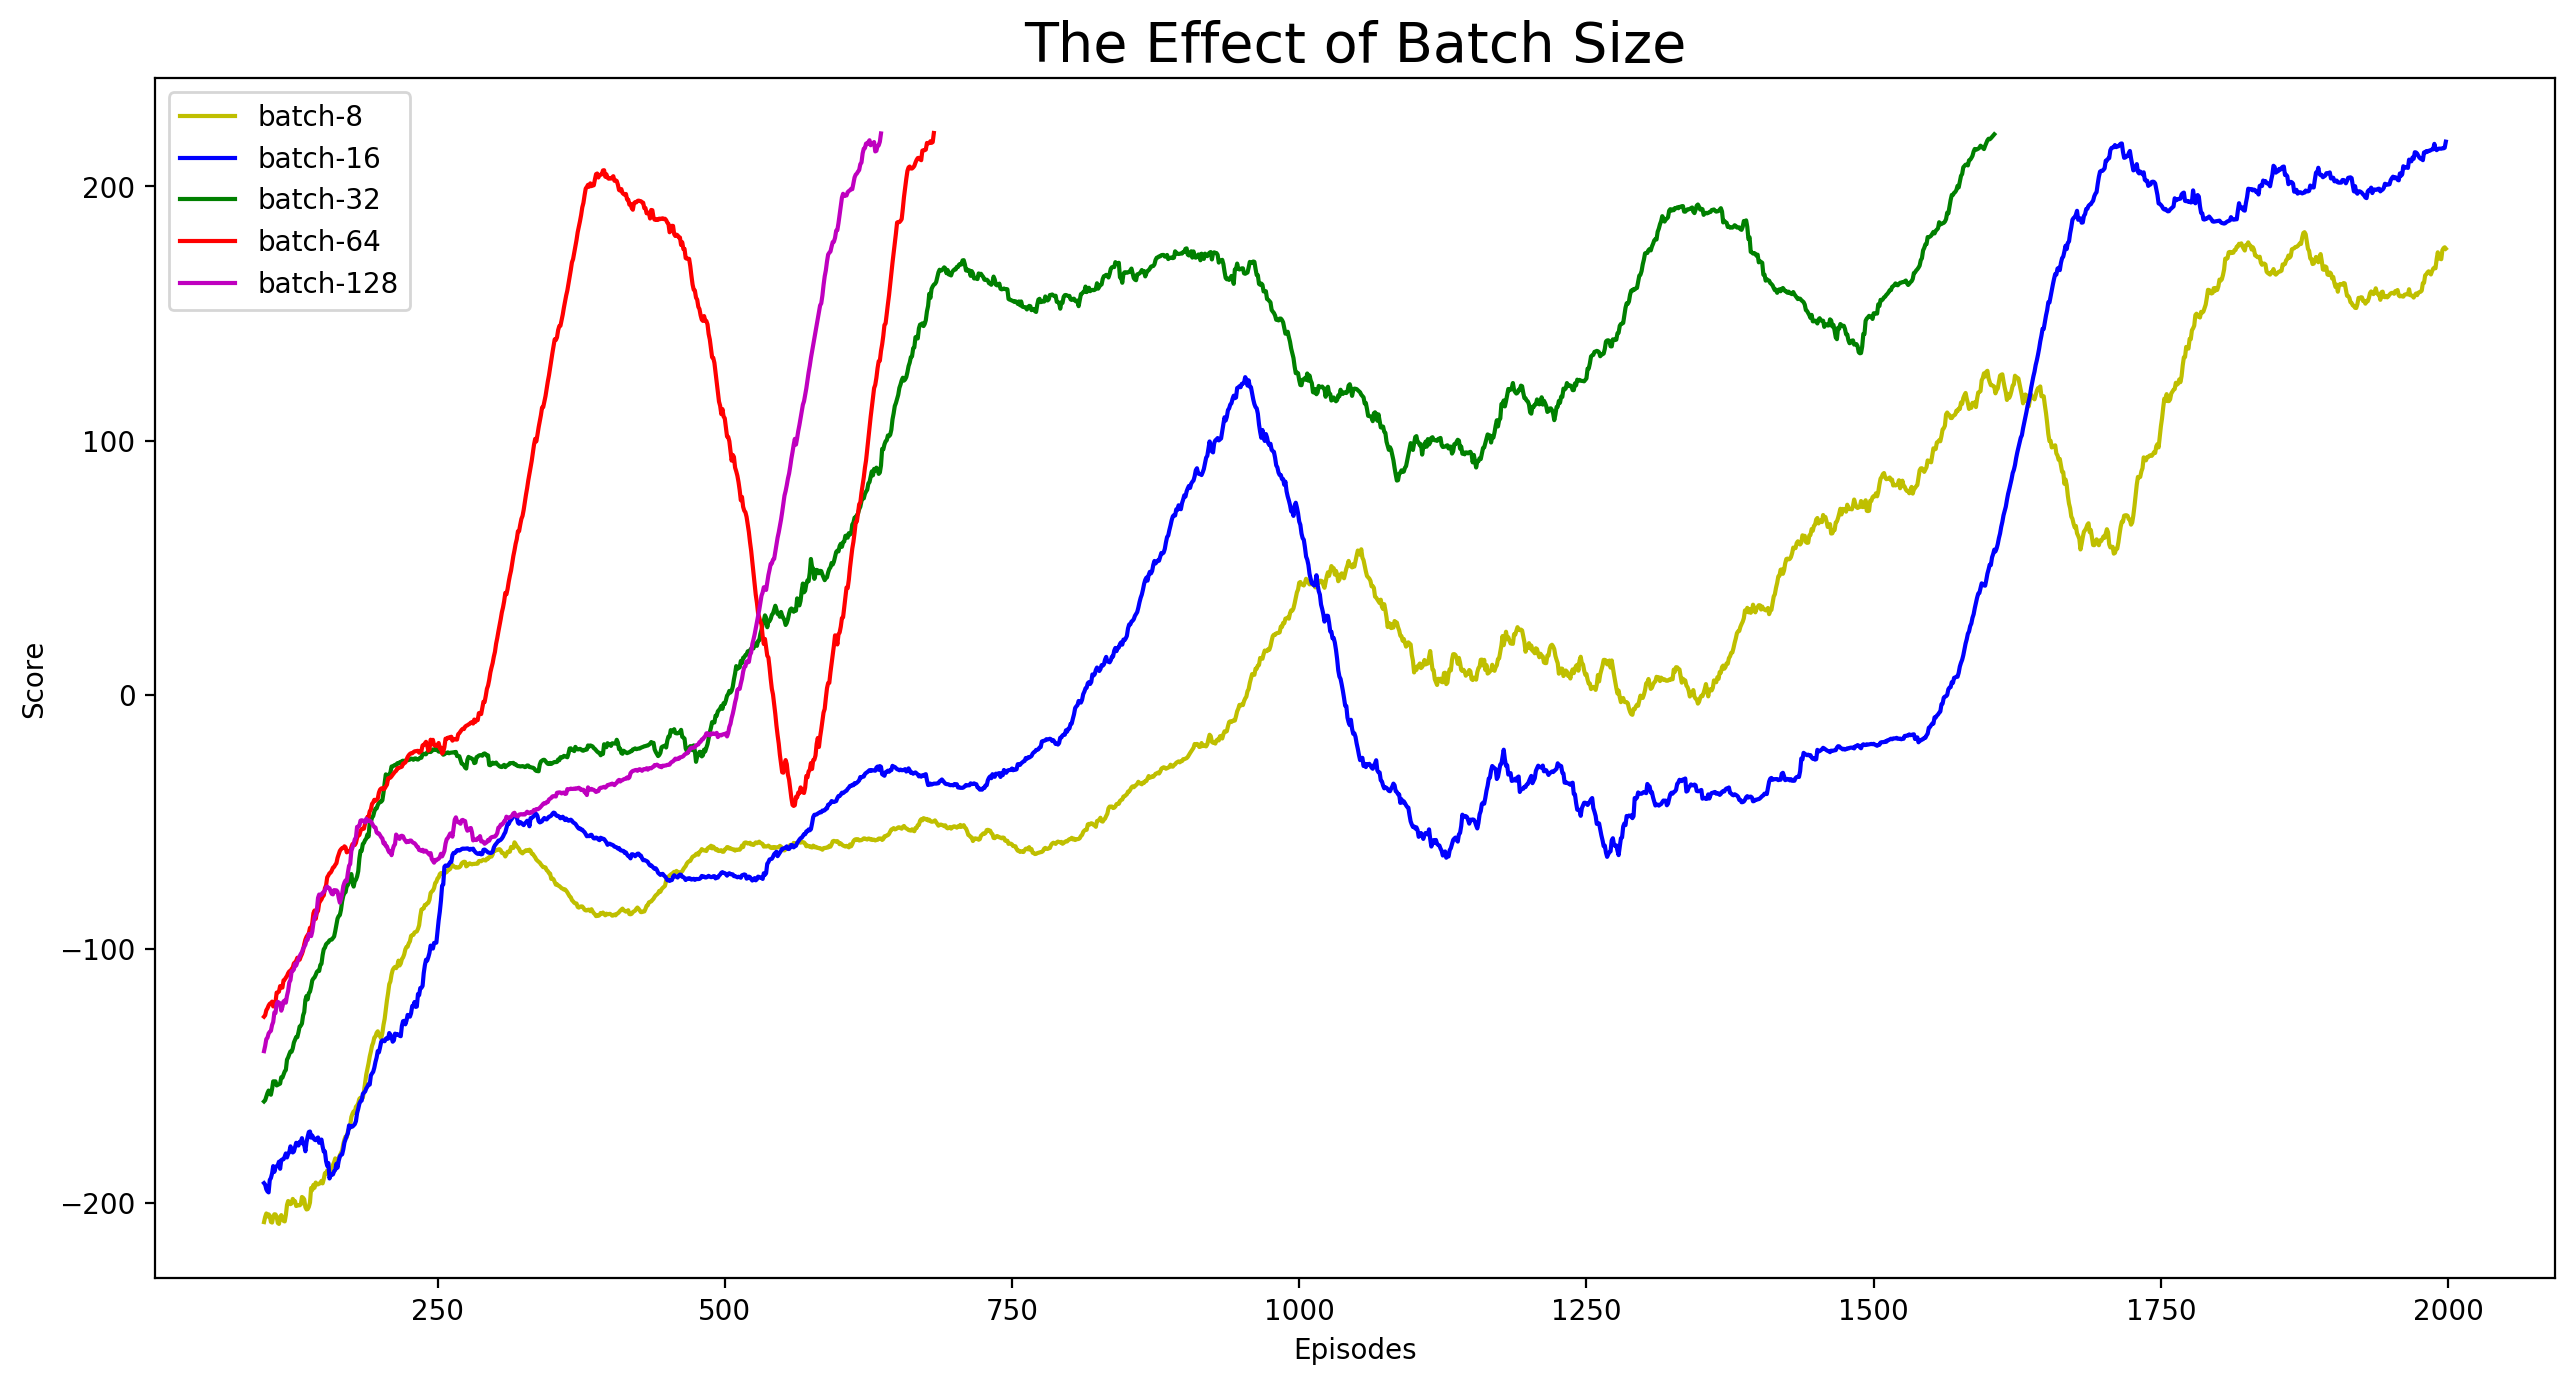

In [11]:
fig=plt.figure(figsize=(12,6),dpi=200)
ax=fig.add_axes([0,0,1,1])
batch8=ax.plot(pd.Series(scores[0]).rolling(window=100).mean(),'y',label='batch-8')
batch16=ax.plot(pd.Series(scores[1]).rolling(window=100).mean(),'b',label='batch-16',alpha=1)
batch32=ax.plot(pd.Series(scores[2]).rolling(window=100).mean(),'g',label='batch-32',alpha=1)
batch64=ax.plot(pd.Series(scores[3]).rolling(window=100).mean(),'r',label='batch-64',alpha=1)
batch128=ax.plot(pd.Series(scores[4]).rolling(window=100).mean(),'m',label='batch-128',alpha=1)
ax.legend(loc=0)
ax.set_title("The Effect of Batch Size",size=20)
ax.set_xlabel("Episodes")
ax.set_ylabel("Score")